<a href="https://colab.research.google.com/github/aishstronomer/flare-finder/blob/main/solar_image_flare_labels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

to-do:
 - store solar_images big-flare labels in a file: big_flare_labels.csv

In [20]:
# set globals

# Do Google Colab things
try:
    from google.colab import drive

    drive.mount("/content/drive", force_remount=True)
    IN_COLAB = True
except:
    IN_COLAB = False

# standard imports
import glob
import os
import pandas as pd
import sys

In [21]:
# we want a function get_is_big_flare() that has the following schema:
# - input: solar_image_path
# - output: is_big_flare (bool)


def get_is_big_flare(solar_image_path, big_flare_max_dttimes, tolerance):

    is_big_flare = False

    # get datetime of solar_image_path: solar_image_datetime
    solar_image_fname = os.path.basename(solar_image_path)
    solar_image_datetime = pd.to_datetime(
        solar_image_fname[0 : solar_image_fname.rfind(".png")]
    ).replace(tzinfo=None)

    # compare solar_image_datetime with max_datetimes and set is_big_flare to True
    # if solar_image_datetime within some tolerance of max_datetimes
    min_time_delta = min(abs(solar_image_datetime - big_flare_max_dttimes))
    if min_time_delta < tolerance:
        is_big_flare = True

    return is_big_flare


# get big_flare_max_dttimes
path_to_coderepo = (
    "/content/drive/MyDrive/ML_project/code_repo/flare-finder" if IN_COLAB else "."
)
goes_file_path = f"{path_to_coderepo}/goes_events_clean_2015.csv"
goes_events_df = pd.read_csv(goes_file_path)
goes_mx_events = goes_events_df[
    goes_events_df["Particulars_a"].str.lower().str.startswith(("m", "x"))
]
big_flare_max_dttimes = pd.to_datetime(goes_mx_events["max_datetime"]).dropna()

get_is_big_flare(
    f"{path_to_coderepo}/../../data/sdo_images/2015-01-01 00:00:12.340000+00:00.png",
    big_flare_max_dttimes,
    pd.to_timedelta(10, "min"),
)

False

In [38]:
# get labels for solar images and store in big_flare_labels.csv


def get_big_flare_labels(solar_images_folder, goes_file_path, big_flare_time_tolerance):
    big_flare_labels_df = pd.DataFrame(
        columns=["solar_image_filename", "is_big_flare", "time_tolerance_minutes"]
    )

    # get big_flare_max_dttimes
    goes_events_df = pd.read_csv(goes_file_path)
    goes_mx_events = goes_events_df[
        goes_events_df["Particulars_a"].str.lower().str.startswith(("m", "x"))
    ]
    big_flare_max_dttimes = pd.to_datetime(goes_mx_events["max_datetime"]).dropna()

    # get solar_image_paths
    solar_image_paths = glob.glob(f"{solar_images_folder}/*png")

    # for each solar image path, get is_big_flare and populate df
    time_tolerance_minutes = big_flare_time_tolerance.total_seconds() / 60
    for i, solar_image_path in enumerate(solar_image_paths[0:None]):
        is_big_flare = get_is_big_flare(
            solar_image_path, big_flare_max_dttimes, big_flare_time_tolerance
        )
        big_flare_labels_df.loc[len(big_flare_labels_df)] = (
            os.path.basename(solar_image_path),
            is_big_flare,
            time_tolerance_minutes,
        )

    return big_flare_labels_df


goes_file_path = f"{path_to_coderepo}/goes_events_clean_2015.csv"
solar_images_folder = f"{path_to_coderepo}/../../data/sdo_images"

big_flare_labels_df = get_big_flare_labels(
    solar_images_folder, goes_file_path, pd.to_timedelta(5, "min")
)
big_flare_labels_df.to_csv(f"{solar_images_folder}/big_flare_labels.csv", index=False)
pd.read_csv(f"{solar_images_folder}/big_flare_labels.csv")

,solar_image_filename,is_big_flare,time_tolerance_minutes
0,2015-01-08 07:00:12.340000+00:00.png,False,5.0
1,2015-04-03 23:00:12.340000+00:00.png,False,5.0
2,2015-10-25 20:00:11.340000+00:00.png,False,5.0
3,2015-11-29 17:00:11.340000+00:00.png,False,5.0
4,2015-01-11 22:00:12.340000+00:00.png,False,5.0
...,...,...,...
8545,2015-03-02 01:00:12.340000+00:00.png,False,5.0
8546,2015-01-17 10:00:12.340000+00:00.png,False,5.0
8547,2015-03-26 09:00:12.340000+00:00.png,False,5.0
8548,2015-11-12 08:00:11.340000+00:00.png,False,5.0


In [39]:
big_flare_labels_df['is_big_flare'].value_counts()

is_big_flare
False    8432
True      118
Name: count, dtype: int64

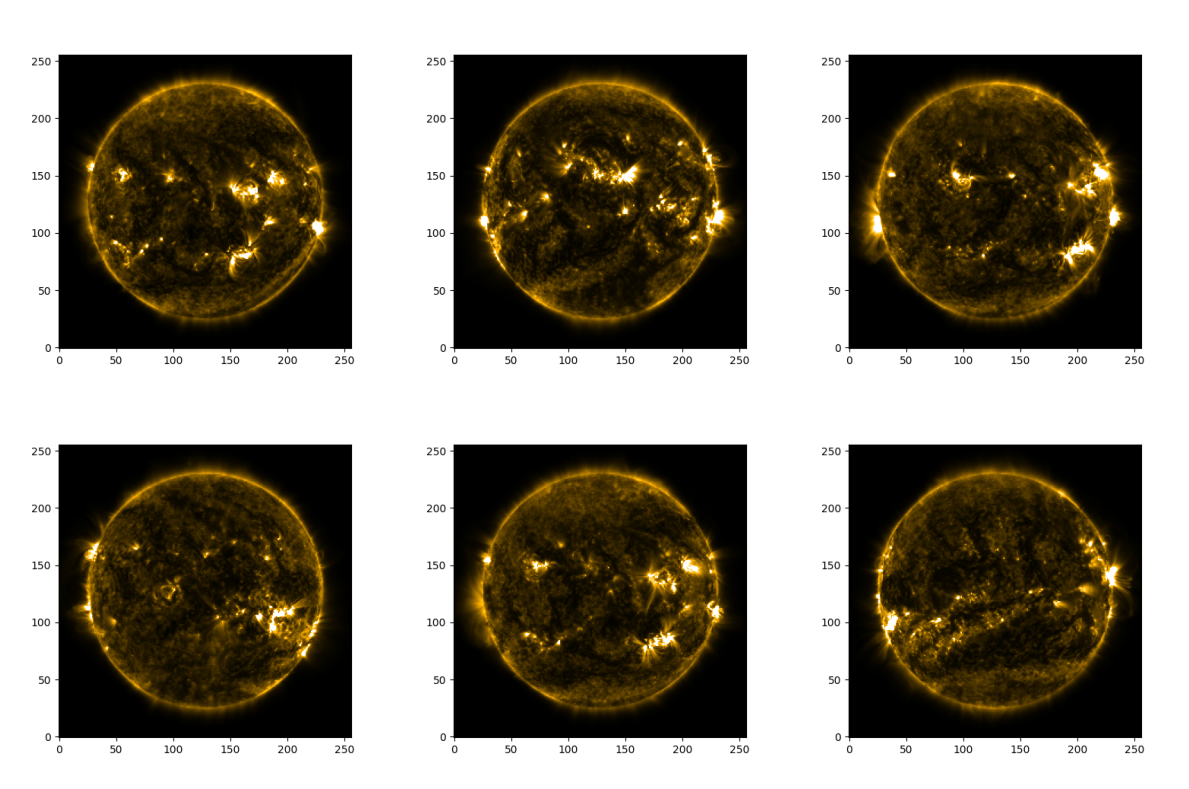

In [47]:
# plot some solar images with is_big_flare == True
import matplotlib.pyplot as plt
from PIL import Image

plot_df = big_flare_labels_df[big_flare_labels_df["is_big_flare"] == True].sample(6, random_state=0)

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
for i, ax in enumerate(axs.flat):
    solar_image_path = f"{solar_images_folder}/{plot_df.iloc[i]['solar_image_filename']}"
    solar_image = Image.open(solar_image_path)
    ax.imshow(solar_image)
    # ax.set_title(big_flare_labels_df.iloc[i]["solar_image_filename"])
    ax.axis("off")
plt.tight_layout()
plt.show()

In [44]:
plot_df.sort_values('solar_image_filename')

,solar_image_filename,is_big_flare,time_tolerance_minutes
3177,2015-01-03 09:48:13.660000+00:00.png,True,5.0
1891,2015-01-04 15:36:13.460000+00:00.png,True,5.0
2390,2015-01-13 04:24:13.730000+00:00.png,True,5.0
5289,2015-01-13 05:00:12.340000+00:00.png,True,5.0
5188,2015-01-14 13:00:12.350000+00:00.png,True,5.0
...,...,...,...
6901,2015-12-21 10:18:11.350000+00:00.png,True,5.0
7356,2015-12-22 03:36:11.340000+00:00.png,True,5.0
5139,2015-12-23 00:42:11.340000+00:00.png,True,5.0
7674,2015-12-24 02:12:11.340000+00:00.png,True,5.0


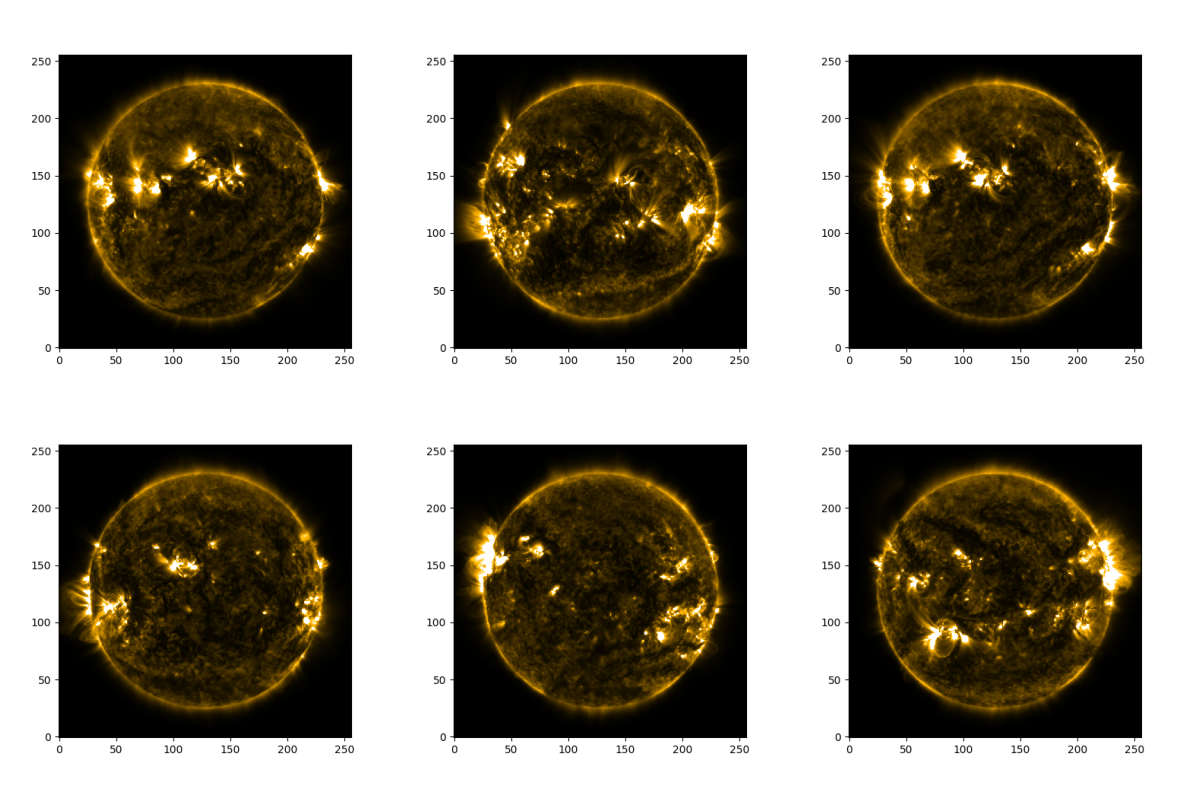

In [48]:
# plot 6 solar images with is_big_flare == False in a 3by2 grid

plot_df = big_flare_labels_df[big_flare_labels_df["is_big_flare"] == False].sample(6, random_state=0)

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
for i, ax in enumerate(axs.flat):
    solar_image_path = f"{solar_images_folder}/{plot_df.iloc[i]['solar_image_filename']}"
    solar_image = Image.open(solar_image_path)
    ax.imshow(solar_image)
    # ax.set_title(big_flare_labels_df.iloc[i]["solar_image_filename"])
    ax.axis("off")
plt.tight_layout()
plt.show()